In [1]:
from stoch_quant import sq_compress,sq_decompress,get_sq_compressable_extraction
from drive import drive_compress, drive_decompress
from fedavg import fedavg_compress, fedavg_decompress
import torch
import numpy as np

In [74]:
def acc_DRIVE(clients,l):
    # sender and receiver should use the same seed:
    seed = 42

    sgen = torch.Generator(device="cuda")
    sgen.manual_seed(seed)

    rgen = torch.Generator(device="cuda")
    rgen.manual_seed(seed)

    vec1 = [torch.from_numpy(np.random.chisquare(3,2**l)).cuda() for c in range(clients)]
    vec2 = [torch.from_numpy(np.random.normal(0,5,2**l)).cuda() for c in range(clients)]
    vec3 = [torch.from_numpy(np.random.exponential(3,2**l)).cuda() for c in range(clients)]


    acc = []
    c1time = 0
    stime = 0
    c2time = 0
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    for vec in [vec1,vec2,vec3]:
        grad_vec = torch.zeros(2**l,device=torch.device("cuda"))
        vec_sum = torch.zeros(2**l,device=torch.device("cuda"))
        for v in vec:
            vec_sum += v
            start.record()
            s_vec, scale = drive_compress(v,prng=sgen)
            end.record()
            torch.cuda.synchronize()
            c1time += start.elapsed_time(end)
            start.record()
            grad_vec += drive_decompress(s_vec,scale,rgen)
            end.record()
            torch.cuda.synchronize()
            stime += start.elapsed_time(end)
        grad_vec /= clients
        vec_sum /= clients
        acc.append(((grad_vec-vec_sum)**2).mean().item()**0.5)
    c2s = 1
    s2c = 32
    c1time /= clients*3
    stime /= 3
    return acc,c2s,s2c,c1time,stime,c2time

In [75]:
def acc_sq(clients,l,bits):

    vec1 = [torch.from_numpy(np.random.chisquare(df=3,size = 2**l)).cuda() for c in range(clients)]
    vec2 = [torch.from_numpy(np.random.normal(0,5,2**l)).cuda() for c in range(clients)]
    vec3 = [torch.from_numpy(np.random.exponential(3,2**l)).cuda() for c in range(clients)]


    acc = []
    c1time = 0
    stime = 0
    c2time = 0
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    for vec in [vec1,vec2,vec3]:
        c_v_sum = torch.zeros(2**l,device=torch.device("cuda"))
        grad_vec = torch.zeros(2**l,device=torch.device("cuda"))
        vec_sum = torch.zeros(2**l,device=torch.device("cuda"))
        max_val = max([torch.max(v) for v in vec])
        min_val = min([torch.min(v) for v in vec])
        for v in vec:
            vec_sum += v
            start.record()
            c_v = sq_compress(v,max_val,min_val,bits=bits)
            end.record()
            torch.cuda.synchronize()
            c1time += start.elapsed_time(end)
            start.record()
            c_v_sum += c_v
            end.record()
            torch.cuda.synchronize()
            stime += start.elapsed_time(end)
        start.record()
        grad_vec = sq_decompress(c_v_sum,max_val,min_val,bits=bits,clients=clients)
        end.record()
        torch.cuda.synchronize()
        c2time += start.elapsed_time(end)
        grad_vec /= clients
        vec_sum /= clients
        acc.append(((grad_vec-vec_sum)**2).mean().item()**0.5)
    c2s = bits
    s2c = np.log2(clients*(2**bits-1))
    c1time /= clients*3
    stime /= 3
    c2time /= 3
    return acc,c2s,s2c,c1time,stime,c2time

In [76]:
def acc_sq_1(clients,l,bits,p):

    vec1 = [torch.from_numpy(np.random.chisquare(df=3,size = 2**l).astype(np.float32)).cuda() for c in range(clients)]
    vec2 = [torch.from_numpy(np.random.normal(0,5,2**l).astype(np.float32)).cuda() for c in range(clients)]
    vec3 = [torch.from_numpy(np.random.exponential(3,2**l).astype(np.float32)).cuda() for c in range(clients)]


    acc = []
    c1time = 0
    stime = 0
    c2time = 0
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    for vec in [vec1,vec2,vec3]:
        c_v_sum = torch.zeros(2**l,device=torch.device("cuda"))
        e_v_sum = torch.zeros(2**l,device=torch.device("cuda"))
        grad_vec = torch.zeros(2**l,device=torch.device("cuda"))
        vec_sum = torch.zeros(2**l,device=torch.device("cuda"))
        max_val = -1000000000000
        min_val = 1000000000000

        for v in vec:
            vec_sum += v
            a,b = get_sq_compressable_extraction(v,p)
            max_val = max(max_val,torch.max(a))
            min_val = min(min_val,torch.min(a))
        for v in vec:
            start.record()
            a,b = get_sq_compressable_extraction(v,p)
            c_v = sq_compress(a,max_val,min_val,bits=bits)
            end.record()
            torch.cuda.synchronize()
            c1time += start.elapsed_time(end)
            start.record()
            c_v_sum += c_v
            e_v_sum += b
            end.record()
            torch.cuda.synchronize()
            stime += start.elapsed_time(end)
        start.record()
        grad_vec = sq_decompress(c_v_sum,max_val*clients,min_val*clients,bits=bits,clients=clients) + e_v_sum
        end.record()
        torch.cuda.synchronize()
        c2time += start.elapsed_time(end)
        grad_vec /= clients
        vec_sum /= clients
        acc.append(((grad_vec-vec_sum)**2).mean().item()**0.5)
    c2s = (bits*(1-p))+32*p
    s2c = 32*p + (1-p)*np.log2(clients*(2**bits-1))
    c1time /= clients*3
    stime /= 3
    c2time /= 3
    return acc,c2s,s2c,c1time,stime,c2time

In [86]:
l=15
c2s = []
s2c = []
accs = []
clients = 100
fs = [acc_DRIVE,acc_sq,acc_sq_1]
c1times = []
stimes = []
c2times = []
for i in range(len(fs)):
    c2s.append([])
    s2c.append([])
    accs.append([])
    c1times.append([])
    stimes.append([])
    c2times.append([])
    func = fs[i]
    if i == 0:
        a,b,c,d,e,f = func(clients,l)
        accs[-1].append(a)
        c2s[-1].append(b)
        s2c[-1].append(c)
        c1times[-1].append(d)
        stimes[-1].append(e)
        c2times[-1].append(f)
    elif i == 1:
        for j in range(1,4):
            a,b,c,d,e,f = func(clients,l,j)
            accs[-1].append(a)
            c2s[-1].append(b)
            s2c[-1].append(c)
            c1times[-1].append(d)
            stimes[-1].append(e)
            c2times[-1].append(f)
    elif i == 2:
        for j in range(1,4):
            for k in [2**-6,2**-10]:
                a,b,c,d,e,f = func(clients,l,j,k)
                accs[-1].append(a)
                c2s[-1].append(b)
                s2c[-1].append(c)
                c1times[-1].append(d)
                stimes[-1].append(e)
                c2times[-1].append(f)

In [89]:
s = 1
x = []
y = []
chi_acc = []
normal_acc = []
exp_acc = []
c = ["blue","red","green"]
for i in range(len(c2s)):
    for j in range(len(c2s[i])):
        acc = accs[i][j]
        x.append(s2c[i][j])
        y.append(c2s[i][j])
        chi_acc.append(acc[0])
        normal_acc.append(acc[1])
        exp_acc.append(acc[2])
chi_acc = np.array(chi_acc)*50
normal_acc = np.array(normal_acc)*50
exp_acc = np.array(exp_acc)*50


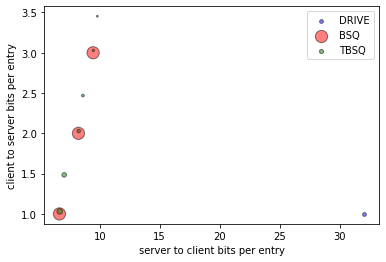

In [93]:
import matplotlib.pyplot as plt

accuracy = chi_acc

plt.scatter(x[0],y[0],alpha=0.5,s=accuracy[0],c=c[0],ec='k',label="DRIVE")
plt.scatter(x[1:4],y[1:4],alpha=0.5,s=accuracy[1:4],c=c[1],ec='k',label="BSQ")
plt.scatter(x[4:],y[4:],alpha=0.5,s=accuracy[4:],c=c[2],ec='k',label="TBSQ")


plt.xlabel("server to client bits per entry")
plt.ylabel("client to server bits per entry")
plt.legend()

plt.savefig("plots/chi.jpg")

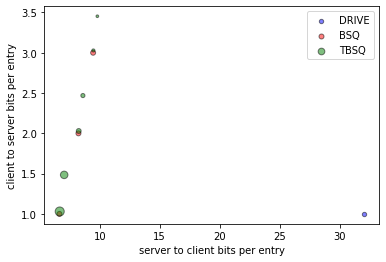

In [94]:
import matplotlib.pyplot as plt

accuracy = normal_acc

plt.scatter(x[0],y[0],alpha=0.5,s=accuracy[0],c=c[0],ec='k',label="DRIVE")
plt.scatter(x[1:4],y[1:4],alpha=0.5,s=accuracy[1:4],c=c[1],ec='k',label="BSQ")
plt.scatter(x[4:],y[4:],alpha=0.5,s=accuracy[4:],c=c[2],ec='k',label="TBSQ")


plt.xlabel("server to client bits per entry")
plt.ylabel("client to server bits per entry")
plt.legend()

plt.savefig("plots/normal.jpg")

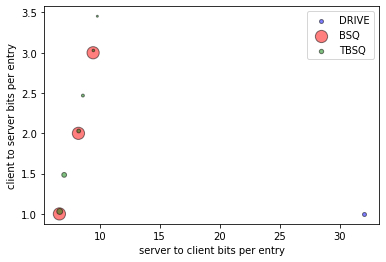

In [95]:
import matplotlib.pyplot as plt

accuracy = exp_acc

plt.scatter(x[0],y[0],alpha=0.5,s=accuracy[0],c=c[0],ec='k',label="DRIVE")
plt.scatter(x[1:4],y[1:4],alpha=0.5,s=accuracy[1:4],c=c[1],ec='k',label="BSQ")
plt.scatter(x[4:],y[4:],alpha=0.5,s=accuracy[4:],c=c[2],ec='k',label="TBSQ")


plt.xlabel("server to client bits per entry")
plt.ylabel("client to server bits per entry")
plt.legend()

plt.savefig("plots/exp.jpg")

In [96]:
print(c1times)

[[3.0544392609596254], [0.39840480012198287, 0.3873666133979956, 0.39340575903654096], [0.6321369597315788, 0.6832989867031575, 0.7050124775369963, 0.6440109851956367, 0.6591692790389061, 0.6841528516014417]]


In [159]:
def times():
    vec_sizes = [2**2,2**6,2**10,2**14,2**18]
    c = 10
    drive_c1times = [0,0,0,0,0]
    drive_c2times = [0,0,0,0,0]
    drive_stimes = [0,0,0,0,0]
    sq_c1times = [0,0,0,0,0]
    sq_c2times = [0,0,0,0,0]
    sq_stimes = [0,0,0,0,0]
    sq1_c1times = [0,0,0,0,0]
    sq1_c2times = [0,0,0,0,0]
    sq1_stimes = [0,0,0,0,0]
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    for _ in range(10):
        for i,s in enumerate(vec_sizes):
            vec = torch.tensor(np.random.uniform(0,999,(s))).cuda()
            start.record()
            sq_comp = sq_compress(vec,999,0,1)
            end.record()
            torch.cuda.synchronize()
            sq_c1times[i]+=start.elapsed_time(end)
            v_sum = torch.zeros(s).cuda()
            start.record()
            for _ in range(c):
                v_sum += sq_comp
            end.record()
            torch.cuda.synchronize()
            sq_stimes[i]+=start.elapsed_time(end)
            start.record()
            sq_decompress(v_sum,999*c,0,1,c)
            end.record()
            torch.cuda.synchronize()
            sq_c2times[i]+=start.elapsed_time(end)
        for i,s in enumerate(vec_sizes):
            device = torch.device("cuda")
            seed = 42
            sgen = torch.Generator(device=device)
            rgen = torch.Generator(device=device)
            sgen.manual_seed(seed)
            rgen.manual_seed(seed)
            vec = torch.tensor(np.random.uniform(0,999,(s))).cuda()
            start.record()
            drive_comp,scale = drive_compress(vec,sgen)
            end.record()
            torch.cuda.synchronize()
            drive_c1times[i]+=start.elapsed_time(end)
            v_sum = torch.zeros(s).cuda()
            start.record()
            for _ in range(c):
                v_sum += drive_decompress(drive_comp,scale,rgen)
            end.record()
            torch.cuda.synchronize()
            drive_stimes[i]+=start.elapsed_time(end)
        for i,s in enumerate(vec_sizes):
            vec = torch.tensor(np.random.uniform(0,999,(s)).astype(np.float32)).cuda()
            start.record()
            small,large = get_sq_compressable_extraction(vec,2**-6)
            sq_comp = sq_compress(small,999,0,1)
            end.record()
            torch.cuda.synchronize()
            sq1_c1times[i]+=start.elapsed_time(end)
            v_sum = torch.zeros(s).cuda()
            l_sum = torch.zeros(s).cuda()
            start.record()
            for _ in range(c):
                v_sum += sq_comp
                l_sum += large
            end.record()
            torch.cuda.synchronize()
            sq1_stimes[i]+=start.elapsed_time(end)
            start.record()
            sq_decompress(v_sum,999*c,0,1,c)+l_sum
            end.record()
            torch.cuda.synchronize()
            sq1_c2times[i]+=start.elapsed_time(end)
    for v in [drive_c1times,drive_stimes,drive_c2times,sq_c1times,sq_stimes,sq_c2times,sq1_c1times,sq1_stimes,sq1_c2times]:
        for i in range(len(v)):
            v[i] /= 10
    return drive_c1times[1:],drive_stimes[1:],drive_c2times[1:],sq_c1times[1:],sq_stimes[1:],sq_c2times[1:],sq1_c1times[1:],sq1_stimes[1:],sq1_c2times[1:]
        


In [160]:
drive_c1times,drive_stimes,drive_c2times,sq_c1times,sq_stimes,sq_c2times,sq1_c1times,sq1_stimes,sq1_c2times = times()
x = [2**6,2**10,2**14,2**18]

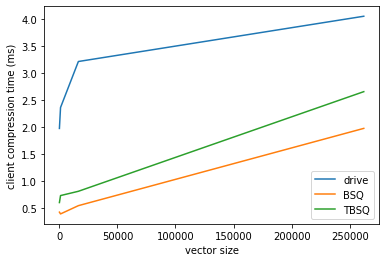

In [162]:
plt.plot(x,drive_c1times,label="drive")
plt.plot(x,sq_c1times,label="BSQ")
plt.plot(x,sq1_c1times,label="TBSQ")
plt.xlabel("vector size")
plt.ylabel("client compression time (ms)")
plt.legend()
plt.savefig("plots/vecsize_c1_speed")

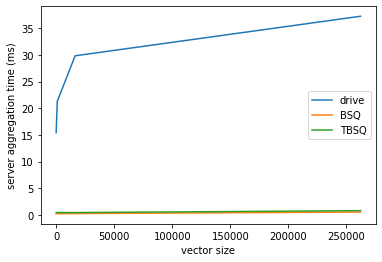

In [163]:
plt.plot(x,drive_stimes,label="drive")
plt.plot(x,sq_stimes,label="BSQ")
plt.plot(x,sq1_stimes,label="TBSQ")
plt.xlabel("vector size")
plt.ylabel("server aggregation time (ms)")
plt.legend()
plt.savefig("plots/vecsize_s_speed")

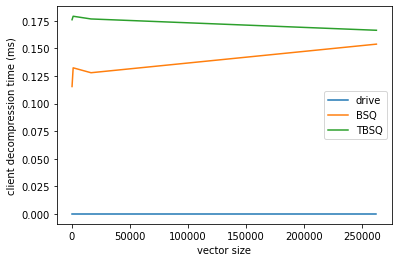

In [164]:
plt.plot(x,drive_c2times,label="drive")
plt.plot(x,sq_c2times,label="BSQ")
plt.plot(x,sq1_c2times,label="TBSQ")
plt.xlabel("vector size")
plt.ylabel("client decompression time (ms)")
plt.legend()
plt.savefig("plots/vecsize_c2_speed")

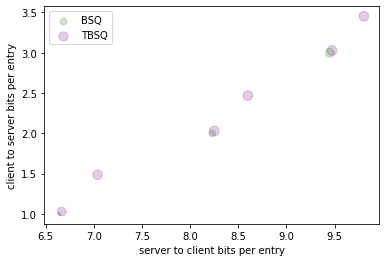

In [177]:
train_acc = [97.444,96.870,10.00,46.684,77.058,93.528,76.396,96.678,97.030,97.244,97.160]
test_acc = [90.10,89.82,10.00,47.27,76.16,87.84,73.60,89.45,89.94,89.43,89.98]
c = ["red","blue","green","purple"]
c2s = [32,1,1,2,3,1*(1-2**-6)+32*(2**-6),1*(1-2**-10)+32*(2**-10),2*(1-2**-6)+32*(2**-6),2*(1-2**-10)+32*(2**-10),3*(1-2**-6)+32*(2**-6),3*(1-2**-10)+32*(2**-10)]
s2c = [32,32,np.log2(clients*(2**1-1)),np.log2(clients*(2**2-1)),np.log2(clients*(2**3-1)),32*(2**-6) + (1-(2**-6))*np.log2(clients*(2**1-1)),32*(2**-10) + (1-(2**-10))*np.log2(clients*(2**1-1)),32*(2**-6) + (1-(2**-6))*np.log2(clients*(2**2-1)),32*(2**-10) + (1-(2**-10))*np.log2(clients*(2**2-1)),32*(2**-6) + (1-(2**-6))*np.log2(clients*(2**3-1)),32*(2**-10) + (1-(2**-10))*np.log2(clients*(2**3-1))]
#plt.scatter(s2c[0],c2s[0],alpha=0.2,s=train_acc[0],c=c[0],label="FedAvg")
#plt.scatter(s2c[1],c2s[1],alpha=0.2,s=train_acc[1],c=c[1],label="DRIVE")
plt.scatter(s2c[2:5],c2s[2:5],alpha=0.2,s=train_acc[2:5],c=c[2],label="BSQ")
plt.scatter(s2c[5:],c2s[5:],alpha=0.2,s=train_acc[5:],c=c[3],label="TBSQ")


plt.xlabel("server to client bits per entry")
plt.ylabel("client to server bits per entry")
plt.legend()
plt.savefig("plots/CIFAR10_ResNet9_train_acc_BSQ_TBSQ")


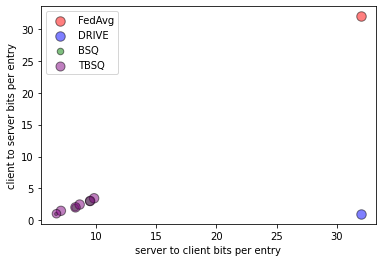

In [174]:
plt.scatter(s2c[0],c2s[0],alpha=0.5,s=test_acc[0],c=c[0],ec='k',label="FedAvg")
plt.scatter(s2c[1],c2s[1],alpha=0.5,s=test_acc[1],c=c[1],ec='k',label="DRIVE")
plt.scatter(s2c[2:5],c2s[2:5],alpha=0.5,s=test_acc[2:5],c=c[2],ec='k',label="BSQ")
plt.scatter(s2c[5:],c2s[5:],alpha=0.5,s=test_acc[5:],c=c[3],ec='k',label="TBSQ")


plt.xlabel("server to client bits per entry")
plt.ylabel("client to server bits per entry")
plt.legend()
plt.savefig("plots/CIFAR10_ResNet9_test_acc")